In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 10-2 (Routing - Semantic Routing)"

# Routing

![](images/routing-01.png)

# Part 10-2: Semantic Routing

![](images/10-02-semantic-routing.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKOn2OVXPxH5bSwWoOfJjfNAJynJu', 'finish_reason': 'stop', 'logprobs': None}, id='run-c96f0e2b-e66a-49a6-9eea-8cbd69c72ef0-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## RAG

In [7]:
from typing import TypedDict

from langchain_community.utils.math import cosine_similarity
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph

In [8]:
prompt_names = ['PHYSICS', 'MATH', 'OTHER']

In [9]:
physics_prompt_template = """You are a very smart physics professor.
You are great at answering questions about physics in a concise and easy to understand manner.
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{question}"""
print(physics_prompt_template)

You are a very smart physics professor.
You are great at answering questions about physics in a concise and easy to understand manner.
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{question}


In [10]:
math_prompt_template = """You are a very good mathematician. You are great at answering math questions.
You are so good because you are able to break down hard problems into their component parts,
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{question}"""
print(math_prompt_template)

You are a very good mathematician. You are great at answering math questions.
You are so good because you are able to break down hard problems into their component parts,
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{question}


In [11]:
other_prompt_template = f"""You are a helpful assistant. You are great at answering all questions not from the following themes: {prompt_names[:-1]}

Here is a question:
{{question}}"""
print(other_prompt_template)

You are a helpful assistant. You are great at answering all questions not from the following themes: ['PHYSICS', 'MATH']

Here is a question:
{question}


In [12]:
prompt_templates = [physics_prompt_template, math_prompt_template, other_prompt_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

In [13]:
physics_query = "What's a black hole"
math_query = "What is the square root of 81"
other_query = "Hello! How are you?"

In [14]:
class State(TypedDict):
    question: str
    most_similar_prompt_idx: int
    most_similar_prompt_name: str
    answer: str

In [15]:
def select_route_prompt(state: State):
    query_embedding = embeddings.embed_query(state['question'])
    query_similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar_prompt_idx = query_similarity.argmax()
    return {
        "most_similar_prompt_idx": most_similar_prompt_idx,
        "most_similar_prompt_name": prompt_names[most_similar_prompt_idx],
    }


def generate_answer(state: State):
    route_prompt = prompt_templates[state["most_similar_prompt_idx"]].format(
        question=state['question']
    )
    response = llm.invoke([
        HumanMessage(content=route_prompt)
    ])
    return {"answer": response.content}

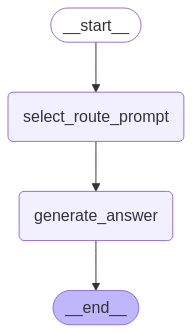

In [16]:
graph_builder = StateGraph(State)

graph_builder.add_node("select_route_prompt", select_route_prompt)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "select_route_prompt")
graph_builder.add_edge("select_route_prompt", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
graph

In [17]:
print(physics_query)

response = graph.invoke({"question": physics_query})
rprint(response)
display(Markdown(response["answer"]))

What's a black hole


{
    'question': "What's a black hole",
    'most_similar_prompt_idx': 0,
    'most_similar_prompt_name': 'PHYSICS',
    'answer': 'A black hole is an astronomical object with an extremely strong gravitational pull, so strong that 
nothing, not even light, can escape from it. This results in a region of space called the event horizon, which 
marks the point beyond which nothing can return. Black holes are formed when massive stars collapse under their own
gravity at the end of their life cycles. They can vary in size, from small black holes just a few times the mass of
the Sun to supermassive black holes that can be millions or billions of times more massive, typically found at the 
centers of galaxies. Black holes are fascinating because they challenge our understanding of physics, particularly 
at the intersection of general relativity and quantum mechanics.'
}

A black hole is an astronomical object with an extremely strong gravitational pull, so strong that nothing, not    
even light, can escape from it. This results in a region of space called the event horizon, which marks the point  
beyond which nothing can return. Black holes are formed when massive stars collapse under their own gravity at the 
end of their life cycles. They can vary in size, from small black holes just a few times the mass of the Sun to    
supermassive black holes that can be millions or billions of times more massive, typically found at the centers of 
galaxies. Black holes are fascinating because they challenge our understanding of physics, particularly at the     
intersection of general relativity and quantum mechanics.

In [18]:
print(math_query)

response = graph.invoke({"question": math_query})
rprint(response)
display(Markdown(response["answer"]))

What is the square root of 81


{
    'question': 'What is the square root of 81',
    'most_similar_prompt_idx': 1,
    'most_similar_prompt_name': 'MATH',
    'answer': 'To solve for the square root of 81, we ask ourselves what number, when multiplied by itself, gives 
us 81.\n\n1. We can break it down by identifying perfect squares near 81:\n   - \\(8^2 = 64\\)\n   - \\(9^2 = 
81\\)\n   - \\(10^2 = 100\\)\n\n2. From this, we see that \\(9 \\times 9 = 81\\).\n\nThus, the square root of 81 is
\\(9\\).\n\nSo, \\(\\sqrt{81} = 9\\).'
}

To solve for the square root of 81, we ask ourselves what number, when multiplied by itself, gives us 81.          

 1 We can break it down by identifying perfect squares near 81:                                                    
    • (8^2 = 64)                                                                                                   
    • (9^2 = 81)                                                                                                   
    • (10^2 = 100)                                                                                                 
 2 From this, we see that (9 \times 9 = 81).                                                                       

Thus, the square root of 81 is (9).                                                                                

So, (\sqrt{81} = 9).

In [19]:
print(other_query)

response = graph.invoke({"question": other_query})
rprint(response)
display(Markdown(response["answer"]))

Hello! How are you?


{
    'question': 'Hello! How are you?',
    'most_similar_prompt_idx': 2,
    'most_similar_prompt_name': 'OTHER',
    'answer': "Hello! I'm doing well, thank you for asking. How can I assist you today?"
}

Hello! I'm doing well, thank you for asking. How can I assist you today?